# Minplus algebra experiment

This code attempts to learn the 64D mixture prior
$J(x) = min(\frac{1}{2t\sigma_{1}}||x-\mu_{1}||^{2}, \frac{1}{2\sigma_{2}}||x-\mu_{2}||^{2})$
assuming we have access to training data $\{y_i, S(y_i)\} = min_{x \in \R} \ \{0.5||x-y_i||^{2}_{2} + J(x)\}\}$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/minplus_64D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the solution S(y,t) of the Hamilton--Jacobi
    PDE for the minplus algebra example at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        hjsol:  An n-dimensional numpy array of numbers
    '''

    val1 = 0.5*pow(euclid_norm(y-mu1),2)/(1+sigma1)
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/(1+sigma2)
    hjsol = np.minimum(val1,val2)
    return hjsol


def prior_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the initial data of the Hamilton--Jacobi
    PDE for the minplus algebra example.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        prior:  An n-dimensional numpy array of numbers
    '''
        
    val1 = 0.5*pow(euclid_norm(y-mu1),2)/sigma1
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/sigma2
    prior = np.minimum(val1,val2)
    return prior


def cvx_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes 0.5*norm(y)_{2}^{2} - S(y,t) at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        cvx:  An n-dimensional numpy array of numbers
    '''

    cvx = 0.5*pow(euclid_norm(y),2) - hjsol_true(y,mu1,mu2,sigma1,sigma2)
    return cvx


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_cvx_true = cvx_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    x1_0_prior_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_prior_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.subplots()
    plt.plot(xi, x1_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x1_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the convex function")
    plt.xlabel('$x_1$')
    plt.ylabel('Convex functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x2_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the convex function")
    plt.xlabel('$x_2$')
    plt.ylabel('Convex functions (0, $x_2$)')
    plt.legend()

    # Plot cross sections of the prior function
    plt.subplots()
    plt.plot(xi, x1_0_prior_est, "-", label="LPN")
    plt.plot(xi, x1_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the prior function")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_prior_est, "-", label="LPN")
    plt.plot(xi, x2_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the prior function")
    plt.xlabel('$x_2$')
    plt.ylabel('Prior functions (0, $x_2$)')
    plt.legend()




def plot_all(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 64

# Prior parameters
mu1 = np.zeros(dim); mu1[0] = 1.0;  sigma1 = 1.0
mu2 = np.ones(dim)/np.sqrt(dim);    sigma2 = 1.0

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 40000
Iterations = 500000

# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 5       # beta of softplus
hidden = 250     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,mu1,mu2,sigma1,sigma2).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-3
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 7536.84375
iteration 0 loss 2616.725830078125


iteration 5000 loss 0.4637115001678467


iteration 10000 loss 0.12685807049274445


iteration 15000 loss 0.05864401161670685


iteration 20000 loss 0.03847748786211014


iteration 25000 loss 0.023033851757645607


iteration 30000 loss 0.01872245781123638


iteration 35000 loss 0.10558413714170456


iteration 40000 loss 0.01033355388790369


iteration 45000 loss 0.01017690822482109


iteration 50000 loss 0.007912040688097477


iteration 55000 loss 0.005863942671567202


iteration 60000 loss 0.004820121917873621


iteration 65000 loss 0.01503385603427887


iteration 70000 loss 0.5505898594856262


iteration 75000 loss 0.004501143470406532


iteration 80000 loss 0.0037096510641276836


iteration 85000 loss 0.6426222324371338


iteration 90000 loss 0.02098725363612175


iteration 95000 loss 0.8962286710739136


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.002575670136138797


iteration 105000 loss 0.000880747102200985


iteration 110000 loss 0.0004860426706727594


iteration 115000 loss 0.0003167883260175586


iteration 120000 loss 0.0002959644771181047


iteration 125000 loss 0.00015243294183164835


iteration 130000 loss 0.00011042974074371159


iteration 135000 loss 8.101959974737838e-05


iteration 140000 loss 6.040016160113737e-05


iteration 145000 loss 0.00013282881991472095


iteration 150000 loss 0.00651515182107687


iteration 155000 loss 0.00020966822921764106


iteration 160000 loss 7.705934694968164e-05


iteration 165000 loss 0.00025601370725780725


iteration 170000 loss 1.5964200429152697e-05


iteration 175000 loss 0.003284313017502427


iteration 180000 loss 1.1983717740804423e-05


iteration 185000 loss 6.440011929953471e-06


iteration 190000 loss 5.394109848566586e-06


iteration 195000 loss 0.000140356773044914


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.000621430401224643


iteration 205000 loss 2.680142188182799e-06


iteration 210000 loss 2.44812486016599e-06


iteration 215000 loss 1.61621267125156e-06


iteration 220000 loss 1.270723259949591e-06


iteration 225000 loss 4.876416642218828e-05


iteration 230000 loss 7.849033067941491e-07


iteration 235000 loss 6.204577402968425e-07


iteration 240000 loss 4.895651386505051e-07


iteration 245000 loss 3.895731879310915e-07


iteration 250000 loss 9.402446266904008e-06


iteration 255000 loss 2.516590029699728e-07


iteration 260000 loss 2.0390389465774206e-07


iteration 265000 loss 3.8198863876459654e-06


iteration 270000 loss 1.4131026659924828e-07


iteration 275000 loss 1.1267361088584948e-07


iteration 280000 loss 9.372499931714628e-08


iteration 285000 loss 7.71897745721617e-08


iteration 290000 loss 6.750534708999112e-08


iteration 295000 loss 5.40152200301236e-07


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 1.1378618580693001e-07


iteration 305000 loss 4.455280944171136e-08


iteration 310000 loss 3.901338985201619e-08


iteration 315000 loss 3.3850216851760706e-08


iteration 320000 loss 3.0148370910865196e-08


iteration 325000 loss 2.6106834027928016e-08


iteration 330000 loss 2.3449510777595606e-08


iteration 335000 loss 2.1025156726750538e-08


iteration 340000 loss 1.8402726453814466e-08


iteration 345000 loss 1.6804991176400108e-08


iteration 350000 loss 1.5136095043999376e-08


iteration 355000 loss 1.3839959400741009e-08


iteration 360000 loss 1.2294517404143335e-08


iteration 365000 loss 1.1491614770875458e-08


iteration 370000 loss 4.2487889118092426e-07


iteration 375000 loss 9.603073891639724e-09


iteration 380000 loss 8.819942998172792e-09


iteration 385000 loss 8.051759259330993e-09


iteration 390000 loss 7.536597124158106e-09


iteration 395000 loss 6.812581609949575e-09


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 6.401350116647109e-09


iteration 405000 loss 6.179010192397527e-09


iteration 410000 loss 5.826883864301635e-09


iteration 415000 loss 5.51167067541769e-09


iteration 420000 loss 5.2723541088539605e-09


iteration 425000 loss 5.033220507044689e-09


iteration 430000 loss 2.3715305275118226e-08


iteration 435000 loss 4.629893801677554e-09


iteration 440000 loss 4.42927072796806e-09


iteration 445000 loss 5.548172339331359e-07


iteration 450000 loss 4.074843573675935e-09


iteration 455000 loss 3.924065516969222e-09


iteration 460000 loss 3.779420776339748e-09


iteration 465000 loss 3.602691034387817e-09


iteration 470000 loss 3.478021870506609e-09


iteration 475000 loss 3.3570828339435366e-09


iteration 480000 loss 3.240536505799696e-09


iteration 485000 loss 3.125457670449805e-09


iteration 490000 loss 3.005903304043045e-09


iteration 495000 loss 2.904987139729087e-09


L2 loss -- Plot

loss -44.77027130126953


loss -230.06983947753906


loss -325.83489990234375


loss -409.8304443359375


loss -487.170166015625


loss -557.7994384765625


loss -621.18408203125


loss -676.835693359375


loss -724.3673706054688


loss -763.511474609375


loss -794.2650146484375


loss -817.0941162109375


loss -832.998291015625


loss -843.3402709960938


loss -849.5635986328125


loss -852.9749145507812


loss -854.6398315429688


loss -855.343505859375


loss -855.5922241210938


loss -855.6624145507812


loss -855.67724609375


loss -855.6793212890625


loss -855.6795043945312


loss -855.6795654296875


loss -855.6795654296875


loss -855.6795654296875


loss -855.6795654296875


loss -855.6795654296875


loss -855.6795654296875


loss -855.6795043945312


loss -855.6795654296875


loss -855.6795043945312


loss -855.6795654296875


loss -855.6795043945312


loss -855.6795654296875


loss -855.6795654296875


loss -855.6795654296875


loss -855.6795654296875


loss -855.6795654296875


loss -855.6795654296875


final mse:  2.852279523679613e-10
max, min: 6.41088 -7.315279
loss -44.77027130126953


loss -227.5647430419922


loss -325.45233154296875


loss -412.2291564941406


loss -492.562744140625


loss -566.2242431640625


loss -632.439453125


loss -690.415771484375


loss -739.587646484375


loss -779.7446899414062


loss -811.126953125


loss -834.51416015625


loss -851.1163330078125


loss -862.3244018554688


loss -869.4822387695312


loss -873.7584838867188


loss -876.1055908203125


loss -877.2604370117188


loss -877.7537841796875


loss -877.9295654296875


loss -877.97900390625


loss -877.9893188476562


loss -877.9907836914062


loss -877.9908447265625


loss -877.9909057617188


loss -877.990966796875


loss -877.990966796875


loss -877.990966796875


loss -877.9909057617188


loss -877.9908447265625


loss -877.990966796875


loss -877.9909057617188


loss -877.990966796875


loss -877.9909057617188


loss -877.990966796875


loss -877.9908447265625


loss -877.9908447265625


loss -877.9909057617188


loss -877.9909057617188


loss -877.9908447265625


final mse:  3.139697113407891e-10
max, min: 7.222414 -7.363019


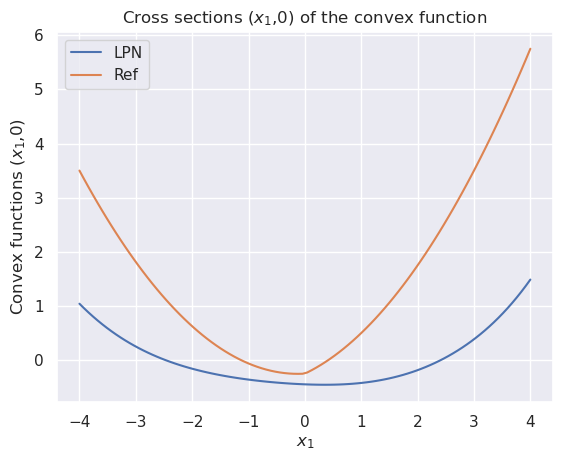

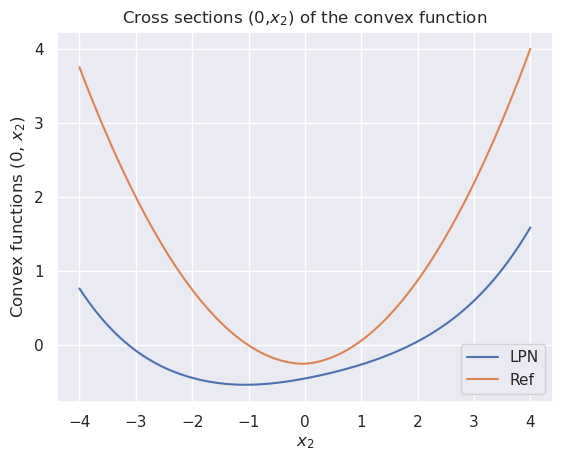

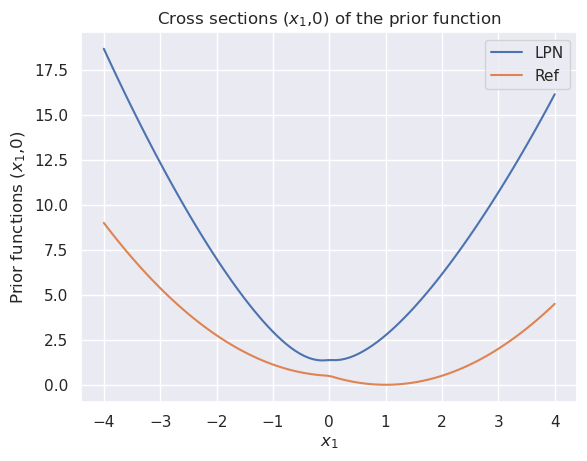

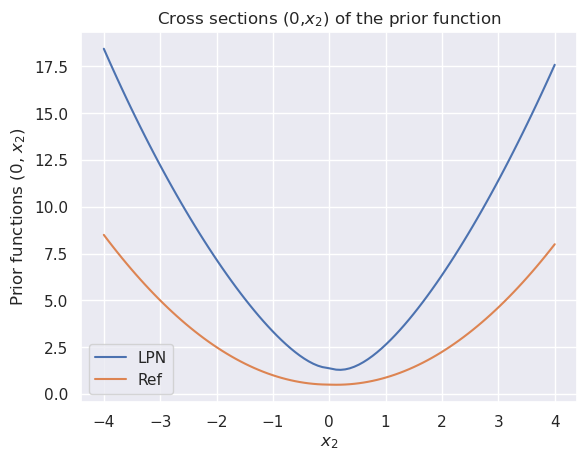

In [7]:
plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

# Detach the tensor to treat G_k as fixed targets, breaking the connection
# to the first LPN's graph and preventing the RuntimeError during training.
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

# The input tensor x_k_tensor is still needed for the second LPN training,
# but it should also not require a gradient for that training.
x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)
# G_samples_tensor now holds the target values G_k
print(f"Generated G samples: G_samples_tensor shape {G_samples_tensor.shape}")

# --- Step 3: Train LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
# The target for this LPN is G_samples_tensor
# The input for this LPN is x_k_tensor
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")

Generated G samples: G_samples_tensor shape torch.Size([40000, 1])

--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 4544.865234375
iteration 0 loss 2288.36962890625


iteration 5000 loss 0.8930957913398743


iteration 10000 loss 0.15612050890922546


iteration 15000 loss 0.09134087711572647


iteration 20000 loss 0.044878680258989334


iteration 25000 loss 0.0372125580906868


iteration 30000 loss 0.024729367345571518


iteration 35000 loss 0.02090630494058132


iteration 40000 loss 0.017961181700229645


iteration 45000 loss 0.013828505761921406


iteration 50000 loss 0.010622147470712662


iteration 55000 loss 0.011046621017158031


iteration 60000 loss 0.009445518255233765


iteration 65000 loss 0.011393438093364239


iteration 70000 loss 0.006364881992340088


iteration 75000 loss 0.005421913228929043


iteration 80000 loss 0.02953626587986946


iteration 85000 loss 0.0054270001128315926


iteration 90000 loss 0.0037877028807997704


iteration 95000 loss 0.0032628150656819344


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.0027347938157618046


iteration 105000 loss 0.0013830901589244604


iteration 110000 loss 0.0008992775692604482


iteration 115000 loss 0.0006442514131776989


iteration 120000 loss 0.0015066636260598898


iteration 125000 loss 0.0003680029767565429


iteration 130000 loss 0.00028745390591211617


iteration 135000 loss 0.00022910618281457573


iteration 140000 loss 0.00018445323803462088


iteration 145000 loss 0.00014554352674167603


iteration 150000 loss 0.00012389928451739252


iteration 155000 loss 9.923035395331681e-05


iteration 160000 loss 8.119284029817209e-05


iteration 165000 loss 6.740979006281123e-05


iteration 170000 loss 0.00041907443664968014


iteration 175000 loss 4.683331280830316e-05


iteration 180000 loss 3.932704930775799e-05


iteration 185000 loss 0.0001612201740499586


iteration 190000 loss 2.7428057364886627e-05


iteration 195000 loss 2.3888282157713547e-05


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 1.980374327104073e-05


iteration 205000 loss 0.003360516158863902


iteration 210000 loss 1.4701750842505135e-05


iteration 215000 loss 1.2296501154196449e-05


iteration 220000 loss 1.047735167958308e-05


iteration 225000 loss 8.880258974386379e-06


iteration 230000 loss 7.539066700701369e-06


iteration 235000 loss 6.403128736565122e-06


iteration 240000 loss 5.0224578444613144e-05


iteration 245000 loss 4.660320882976521e-06


iteration 250000 loss 3.965574251196813e-06


iteration 255000 loss 3.418872438487597e-06


iteration 260000 loss 2.9254081255203346e-06


iteration 265000 loss 2.5113592982961563e-06


iteration 270000 loss 2.211455921496963e-06


iteration 275000 loss 1.8735853473117459e-06


iteration 280000 loss 1.6026805269575561e-06


iteration 285000 loss 1.3824839015796897e-06


iteration 290000 loss 1.1902714049938368e-06


iteration 295000 loss 1.0654395055098576e-06


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 9.166349173028721e-07


iteration 305000 loss 8.619425670985947e-07


iteration 310000 loss 7.506095585085859e-07


iteration 315000 loss 6.54077950912324e-07


iteration 320000 loss 5.722200739910477e-07


iteration 325000 loss 5.017046760258381e-07


iteration 330000 loss 4.4064404391974676e-07


iteration 335000 loss 3.8782542333137826e-07


iteration 340000 loss 3.4273676874363446e-07


iteration 345000 loss 3.0304229881039646e-07


iteration 350000 loss 2.694228555810696e-07


iteration 355000 loss 2.402692871328327e-07


iteration 360000 loss 2.1486221157829277e-07


iteration 365000 loss 1.924559711596885e-07


iteration 370000 loss 1.730783054654239e-07


iteration 375000 loss 1.5596718583310576e-07


iteration 380000 loss 1.4106043977335503e-07


iteration 385000 loss 1.2825417172734888e-07


iteration 390000 loss 1.1646024233868957e-07


iteration 395000 loss 1.0624740554021628e-07


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 9.669967226955123e-08


iteration 405000 loss 9.122523181304132e-08


iteration 410000 loss 8.493861969327554e-08


iteration 415000 loss 7.720433359281742e-08


iteration 420000 loss 7.225251863474114e-08


iteration 425000 loss 6.623414350315215e-08


iteration 430000 loss 6.211951841805785e-08


iteration 435000 loss 5.7041027901050256e-08


iteration 440000 loss 5.366083044577863e-08


iteration 445000 loss 4.958967636525813e-08


iteration 450000 loss 4.6898385619442706e-08


iteration 455000 loss 4.3294640761359915e-08


iteration 460000 loss 4.0962934377830607e-08


iteration 465000 loss 3.7904200667071564e-08


iteration 470000 loss 3.604500165010904e-08


iteration 475000 loss 3.36335475026317e-08


iteration 480000 loss 3.210800159081373e-08


iteration 485000 loss 3.007226823115161e-08


iteration 490000 loss 2.8640714688776825e-08


iteration 495000 loss 3.640916190761345e-08


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


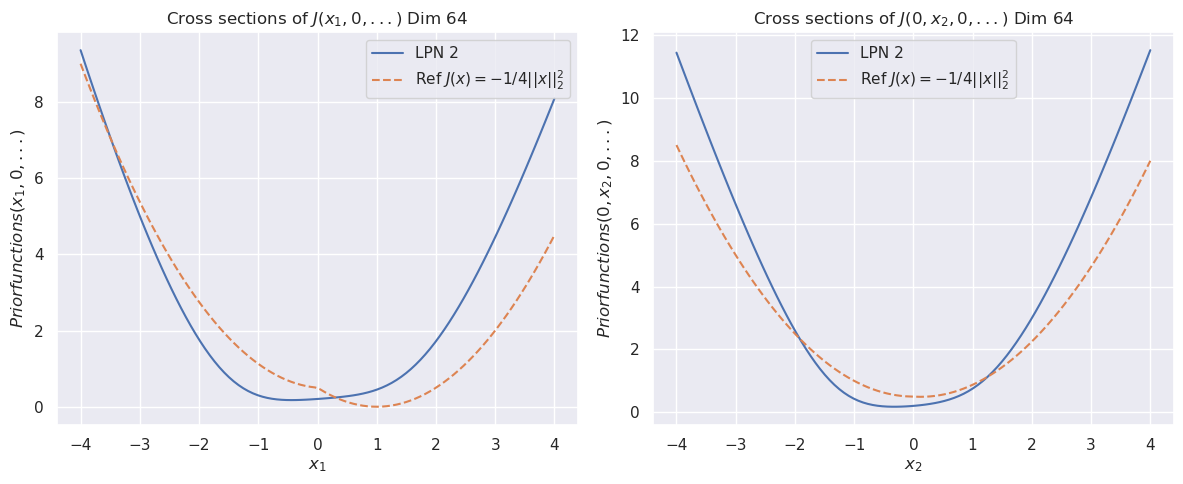

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    # Get G(x) from the second LPN model
    G_x = model_G.scalar(x_tensor)
    
    # Compute 0.5 * ||x||^2
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Prior functions (x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Prior functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    #plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2)